In [1]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import warnings

In [2]:
# Download data
start = '2020-01-01'
end = "2024-08-01"

stock1 = yf.Ticker('^RUT')  # 
stock1_data = stock1.history(interval='1d', start=start, end=end)

stock2 = yf.Ticker('HG=F')  # 
stock2_data = stock2.history(interval='1d', start=start, end=end)

In [3]:
print(stock1_data)
print(stock2_data)

                                  Open         High          Low        Close  \
Date                                                                            
2020-01-02 00:00:00-05:00  1675.900024  1678.140015  1653.520020  1666.770020   
2020-01-03 00:00:00-05:00  1655.020020  1664.040039  1648.540039  1660.869995   
2020-01-06 00:00:00-05:00  1650.660034  1664.849976  1645.510010  1663.260010   
2020-01-07 00:00:00-05:00  1659.729980  1662.099976  1653.329956  1658.310059   
2020-01-08 00:00:00-05:00  1658.469971  1669.290039  1658.229980  1663.589966   
...                                ...          ...          ...          ...   
2024-07-25 00:00:00-04:00  2201.669922  2255.709961  2199.620117  2222.979980   
2024-07-26 00:00:00-04:00  2247.820068  2267.909912  2238.669922  2260.070068   
2024-07-29 00:00:00-04:00  2265.610107  2269.159912  2228.169922  2235.330078   
2024-07-30 00:00:00-04:00  2242.439941  2255.860107  2231.020020  2243.139893   
2024-07-31 00:00:00-04:00  2

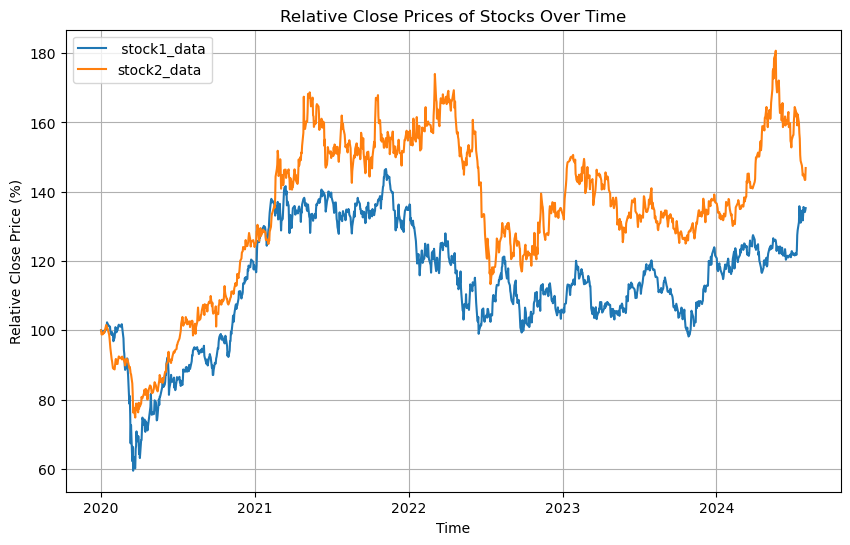

In [4]:
# Charting relative prices
# Define stock names
name_stock1 = " stock1_data"  # Replace with the actual name, e.g., "AAPL"
name_stock2 = "stock2_data"  # Replace with the actual name, e.g., "MSFT"

# Calculate relative prices
stock1_close_relative = stock1_data["Close"] / stock1_data["Close"].iloc[0] * 100
stock2_close_relative = stock2_data["Close"] / stock2_data["Close"].iloc[0] * 100

# Plot the relative prices
plt.figure(figsize=(10, 6))  # Optional: Adjust figure size for better visualization
plt.plot(stock1_close_relative, label=name_stock1)
plt.plot(stock2_close_relative, label=name_stock2)
plt.xlabel('Time')
plt.ylabel('Relative Close Price (%)')
plt.title('Relative Close Prices of Stocks Over Time')
plt.legend()
plt.grid(True)  # Optional: Add grid for better readability
plt.show()


In [5]:
# Align the indices of the two datasets
aligned_data = pd.concat([stock1_data["Close"], stock2_data["Close"]], axis=1, keys=["Stock1", "Stock2"]).dropna()


# Log-transform the aligned data
aligned_data = np.log(aligned_data)

# Remove rows with infinite or NaN values (if any exist after log transformation)
aligned_data.replace([np.inf, -np.inf], np.nan, inplace=True)
aligned_data.dropna(inplace=True)

# Log-transform the align

Y = np.log(aligned_data["Stock2"])
X = np.log(aligned_data["Stock1"])
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(Y, X)
results = model.fit()

# Get parameters
alpha = results.params["const"]
beta = results.params["Stock1"]

# Calculate spread (errors)
errors = Y - (alpha + X["Stock1"] * beta)

print(f"Alpha: {alpha}")
print(f"Beta: {beta}")

Alpha: -12.786480663166056
Beta: 6.462558744591167


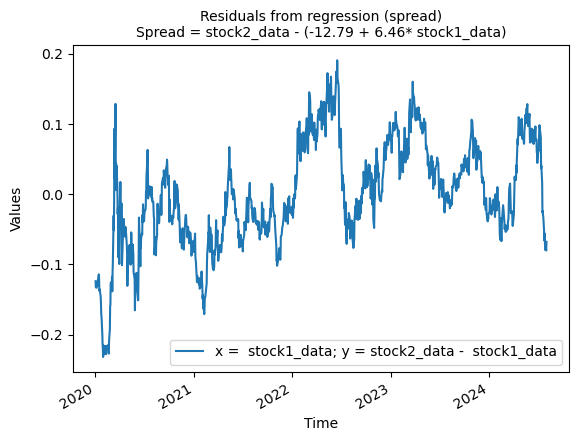

In [6]:
# Charting Spread
errors.plot(label=f"x = {name_stock1}; y = {name_stock2} - {name_stock1}")
plt.title(f'Residuals from regression (spread)\nSpread = {name_stock2} - ({alpha:.2f} + {beta:.2f}*{name_stock1})', fontsize=10)
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.show()

In [7]:
# Dickey Fuller Test
dftest = adfuller(errors, maxlag=1)
dfoutput = pd.Series(dftest[0:4], 
                     index=["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
critical_values = pd.Series(dftest[4].values(), index=dftest[4].keys())

print(f"Dickey Fuller Result:\n{dfoutput} \n\nDickey Fuller Critical Values:\n{critical_values}")

Dickey Fuller Result:
Test Statistic                   -3.436082
p-value                           0.009789
#Lags Used                        1.000000
Number of Observations Used    1150.000000
dtype: float64 

Dickey Fuller Critical Values:
1%    -3.436049
5%    -2.864057
10%   -2.568110
dtype: float64


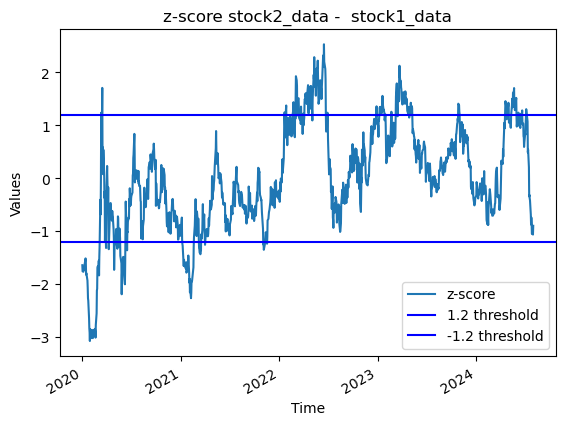

In [8]:
# z-score
spread = errors
zscore = (spread - np.mean(spread)) / np.std(spread)
zscore.plot(label="z-score")
plt.title(f"z-score {name_stock2} - {name_stock1}")
plt.xlabel('Time')
plt.ylabel('Values')
plt.axhline(y=1.2, color='b', label='1.2 threshold')
plt.axhline(y=-1.2, color='b', label='-1.2 threshold')
plt.legend()
plt.show()


In [9]:
# Calculate spread and z-score
spread = stock2_data["Close"] - (alpha + beta * stock1_data["Close"])
zscore = (spread - spread.mean()) / spread.std()

# Define signal thresholds
signal_entry = 1.1
signal_exit = 0.7

# Create backtesting DataFrame
btest = pd.DataFrame()
btest["stock2"] = stock2_data["Close"]
btest["stock1"] = stock1_data["Close"]

# Generate trading signals
btest["short signal"] = (zscore > signal_entry) & (zscore.shift(1) <= signal_entry)
btest["short exit"] = (zscore < signal_exit) & (zscore.shift(1) >= signal_exit)
btest["long signal"] = (zscore < -signal_entry) & (zscore.shift(1) >= -signal_entry)
btest["long exit"] = (zscore > -signal_exit) & (zscore.shift(1) <= -signal_exit)


In [10]:
spread_side = None
counter = -1
backtest_result = []
indicator = 0

for time, signals_stock in btest.iterrows():
    counter += 1
    stock2_, stock1_, short_signal, short_exit, long_signal, long_exit = signals_stock

    if spread_side == None:
        return_stock2 = 0
        return_stock1 = 0
        backtest_result.append([time, return_stock2, return_stock1, spread_side])

        if short_signal == True:
            spread_side = "short"
        elif long_signal == True:
            spread_side = "long"

    elif spread_side == "long":
        return_stock2 = btest["stock2"][counter] / btest["stock2"][counter - 1] - 1.
        return_stock1 = btest["stock1"][counter] / btest["stock1"][counter - 1] - 1.
        backtest_result.append([time, return_stock2, -return_stock1, spread_side])

        if long_exit:
            return_stock2 = btest["stock2"][counter] / btest["stock2"][counter - 1] - 1.
            return_stock1 = btest["stock1"][counter] / btest["stock1"][counter - 1] - 1.
            backtest_result.append([time, return_stock2, -return_stock1, spread_side])
            spread_side = None


    elif spread_side == "short":
        return_stock2 = btest["stock2"][counter] / btest["stock2"][counter - 1] - 1.
        return_stock1 = btest["stock1"][counter] / btest["stock1"][counter - 1] - 1.
        backtest_result.append([time, -return_stock2, return_stock1, spread_side])

        if short_exit == True:
            spread_side = None


/var/folders/_c/ngzs3cn54jn6yhs8fmcmpr180000gn/T/ipykernel_39198/2999842745.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return_stock2 = btest["stock2"][counter] / btest["stock2"][counter - 1] - 1.
/var/folders/_c/ngzs3cn54jn6yhs8fmcmpr180000gn/T/ipykernel_39198/2999842745.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return_stock1 = btest["stock1"][counter] / btest["stock1"][counter - 1] - 1.
/var/folders/_c/ngzs3cn54jn6yhs8fmcmpr180000gn/T/ipykernel_39198/2999842745.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be trea

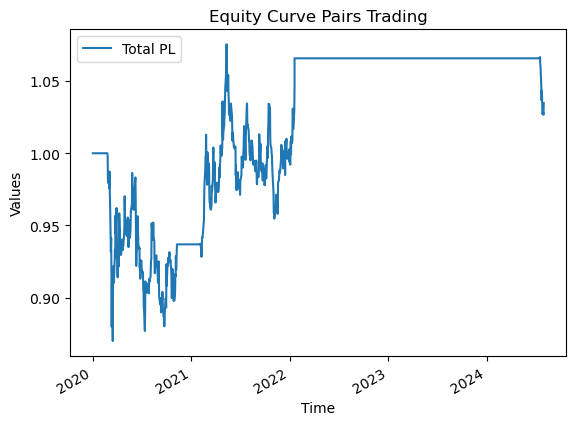

In [11]:
weight_stock1 = 0.5
weight_stock2 = 0.5


backtest_pandas = pd.DataFrame(backtest_result)
backtest_pandas.columns = ["Date", "stock2", "stock1", "Side"]
backtest_pandas["stock2 PL"] = np.cumprod(backtest_pandas["stock2"] + 1.)
backtest_pandas["stock1 PL"] = np.cumprod(backtest_pandas["stock1"] + 1.)
backtest_pandas["Total PL"] = (weight_stock1 * backtest_pandas["stock1 PL"] + weight_stock2 * backtest_pandas["stock2 PL"] )
backtest_pandas.index = backtest_pandas["Date"]

backtest_pandas[["Total PL"]].plot(label="Evolution Profit and Loss")
plt.title("Equity Curve Pairs Trading")
plt.xlabel("Time")
plt.ylabel("Values")
plt.legend()
plt.show()


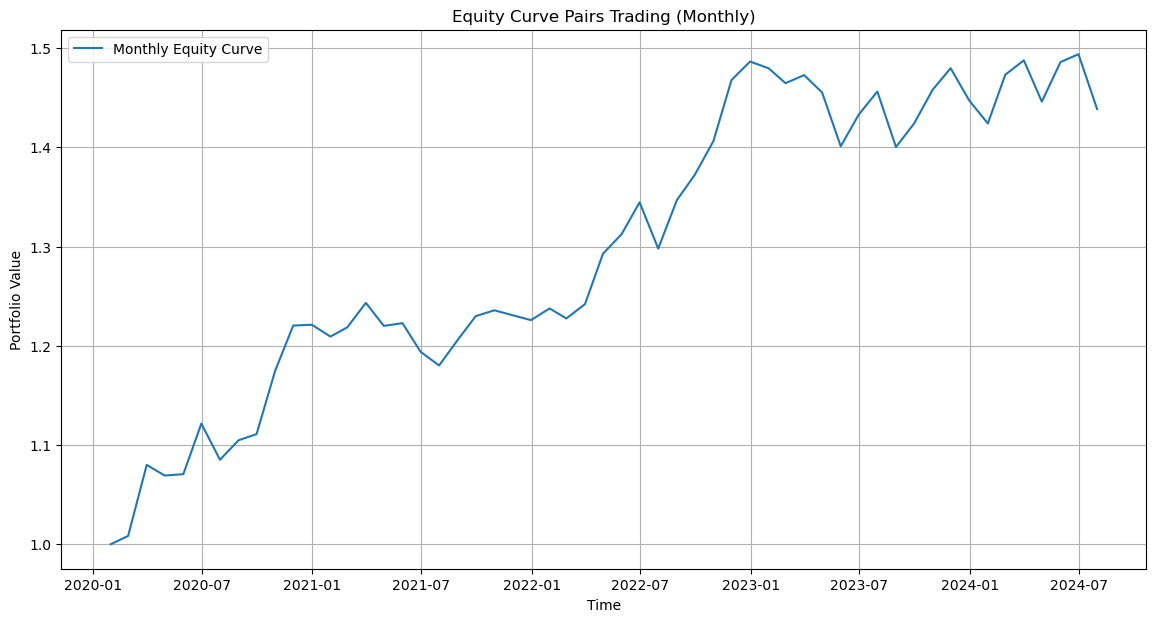

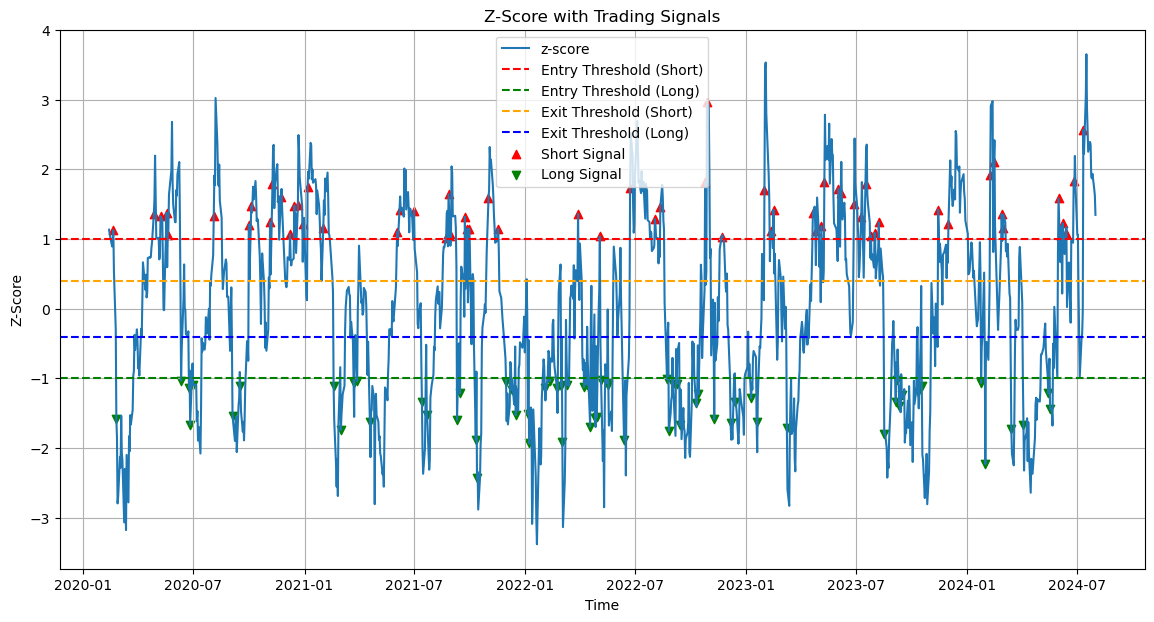

Cumulative Return: 43.87%
Maximum Drawdown: -8.80%
Sharpe Ratio: 0.88
Number of Trades: 72


In [12]:
import pandas as pd
import numpy as np
import yfinance as yf
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import warnings
from ta.momentum import RSIIndicator
from ta.trend import MACD
from ta.volatility import BollingerBands

warnings.filterwarnings("ignore")

# Download data
start = '2020-01-01'
end = "2024-08-01"

stock1 = yf.Ticker('HG=F')  
stock1_data = stock1.history(interval='1d', start=start, end=end)

stock2 = yf.Ticker('^RUT')  
stock2_data = stock2.history(interval='1d', start=start, end=end)

# Align the indices of the two datasets
aligned_data = pd.concat([stock1_data["Close"], stock2_data["Close"]], axis=1, keys=["Stock1", "Stock2"]).dropna()
aligned_data = np.log(aligned_data)
aligned_data.replace([np.inf, -np.inf], np.nan, inplace=True)
aligned_data.dropna(inplace=True)

# Define Y and X
Y = aligned_data["Stock2"]
X = aligned_data["Stock1"]
X_const = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(Y, X_const)
results = model.fit()

alpha = results.params["const"]
beta = results.params["Stock1"]

# Calculate spread
spread = Y - (alpha + beta * X)
aligned_data["Spread"] = spread

# Rolling statistics for Z-score
window = 30
rolling_mean = spread.rolling(window=window).mean()
rolling_std = spread.rolling(window=window).std()
zscore = (spread - rolling_mean) / rolling_std
aligned_data["ZScore"] = zscore

# Add Technical Indicators: RSI, MACD, Bollinger Bands (Optional Filters)
rsi_period = 14
rsi_indicator = RSIIndicator(close=aligned_data["Spread"], window=rsi_period)
aligned_data["RSI"] = rsi_indicator.rsi()

macd_indicator = MACD(close=aligned_data["Spread"], window_slow=26, window_fast=12, window_sign=9)
aligned_data["MACD"] = macd_indicator.macd()
aligned_data["MACD_Signal"] = macd_indicator.macd_signal()

bb_indicator = BollingerBands(close=aligned_data["Spread"], window=20, window_dev=2)
aligned_data["BB_High"] = bb_indicator.bollinger_hband()
aligned_data["BB_Low"] = bb_indicator.bollinger_lband()

# Define signal thresholds (based on Z-score)
signal_entry = 1
signal_exit = 0.4

btest = pd.DataFrame(index=aligned_data.index)
btest["stock2"] = aligned_data["Stock2"]
btest["stock1"] = aligned_data["Stock1"]
btest["spread"] = aligned_data["Spread"]
btest["zscore"] = aligned_data["ZScore"]
btest["RSI"] = aligned_data["RSI"]
btest["MACD"] = aligned_data["MACD"]
btest["MACD_Signal"] = aligned_data["MACD_Signal"]
btest["BB_High"] = aligned_data["BB_High"]
btest["BB_Low"] = aligned_data["BB_Low"]

# Generate trading signals based on z-score and optional filters
btest["short signal"] = ((btest["zscore"] > signal_entry) & (btest["zscore"].shift(1) <= signal_entry))
btest["short exit"] = ((btest["zscore"] < signal_exit) & (btest["zscore"].shift(1) >= signal_exit))

btest["long signal"] = ((btest["zscore"] < -signal_entry) & (btest["zscore"].shift(1) >= -signal_entry))
btest["long exit"] = ((btest["zscore"] > -signal_exit) & (btest["zscore"].shift(1) <= -signal_exit))

# Example additional filter: Only trade if RSI < 70 for long entries and RSI > 30 for short entries (just as an example)
btest["long signal"] = btest["long signal"] & (btest["RSI"] < 70)
btest["short signal"] = btest["short signal"] & (btest["RSI"] > 35)

# Backtesting parameters
slippage = 0.001  # 0.1% slippage
transaction_cost = 0.001  # 0.1% transaction cost

spread_side = None
counter = -1
backtest_result = []
num_trades = 0  # To count the number of trades

for time, signals_stock in btest.iterrows():
    counter += 1
    (stock2_, stock1_, spread_, zscore_,
     RSI_, MACD_, MACD_Signal_, BB_High_, BB_Low_,
     short_signal, short_exit, long_signal, long_exit) = signals_stock

    if spread_side is None:
        return_stock2 = 0
        return_stock1 = 0
        backtest_result.append([time, return_stock2, return_stock1, spread_side])

        # Check for entry signals
        if short_signal:
            spread_side = "short"
            num_trades += 1  # Opening a new short trade
        elif long_signal:
            spread_side = "long"
            num_trades += 1  # Opening a new long trade

    elif spread_side == "long":
        # Calculate returns including slippage and transaction costs
        return_stock2 = btest["stock2"].iloc[counter] / btest["stock2"].iloc[counter - 1] - 1 - transaction_cost - slippage
        return_stock1 = btest["stock1"].iloc[counter] / btest["stock1"].iloc[counter - 1] - 1 - transaction_cost - slippage
        backtest_result.append([time, return_stock2, -return_stock1, spread_side])

        if long_exit:
            spread_side = None

    elif spread_side == "short":
        # Calculate returns including slippage and transaction costs
        return_stock2 = btest["stock2"].iloc[counter] / btest["stock2"].iloc[counter - 1] - 1 - transaction_cost - slippage
        return_stock1 = btest["stock1"].iloc[counter] / btest["stock1"].iloc[counter - 1] - 1 - transaction_cost - slippage
        backtest_result.append([time, -return_stock2, return_stock1, spread_side])

        if short_exit:
            spread_side = None

# Create backtest results DataFrame
backtest_pandas = pd.DataFrame(backtest_result, columns=["Date", "stock2", "stock1", "Side"])
backtest_pandas["stock2 PL"] = np.cumprod(backtest_pandas["stock2"] + 1.)
backtest_pandas["stock1 PL"] = np.cumprod(backtest_pandas["stock1"] + 1.)
backtest_pandas["Total PL"] = (backtest_pandas["stock1 PL"] + backtest_pandas["stock2 PL"]) / 2.
backtest_pandas.set_index("Date", inplace=True)

# Convert daily to monthly
monthly_equity = backtest_pandas["Total PL"].resample('M').last()

# Plot equity curve on monthly basis
plt.figure(figsize=(14, 7))
plt.plot(monthly_equity.index, monthly_equity, label="Monthly Equity Curve")
plt.title("Equity Curve Pairs Trading (Monthly)")
plt.xlabel("Time")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid()
plt.show()

# Plot z-score and signals
plt.figure(figsize=(14, 7))
plt.plot(btest.index, zscore, label="z-score")
plt.axhline(signal_entry, color='red', linestyle='--', label='Entry Threshold (Short)')
plt.axhline(-signal_entry, color='green', linestyle='--', label='Entry Threshold (Long)')
plt.axhline(signal_exit, color='orange', linestyle='--', label='Exit Threshold (Short)')
plt.axhline(-signal_exit, color='blue', linestyle='--', label='Exit Threshold (Long)')
plt.scatter(btest.index[btest["short signal"]], zscore[btest["short signal"]], color='red', label='Short Signal', marker='^')
plt.scatter(btest.index[btest["long signal"]], zscore[btest["long signal"]], color='green', label='Long Signal', marker='v')
plt.title("Z-Score with Trading Signals")
plt.xlabel("Time")
plt.ylabel("Z-Score")
plt.legend()
plt.grid()
plt.show()

# Performance Metrics
cumulative_return = backtest_pandas["Total PL"].iloc[-1] - 1
drawdown = backtest_pandas["Total PL"] / backtest_pandas["Total PL"].cummax() - 1
max_drawdown = drawdown.min()
daily_returns = backtest_pandas["Total PL"].pct_change().dropna()
sharpe_ratio = daily_returns.mean() / daily_returns.std() * np.sqrt(252)

print(f"Cumulative Return: {cumulative_return * 100:.2f}%")
print(f"Maximum Drawdown: {max_drawdown * 100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Number of Trades: {num_trades}")


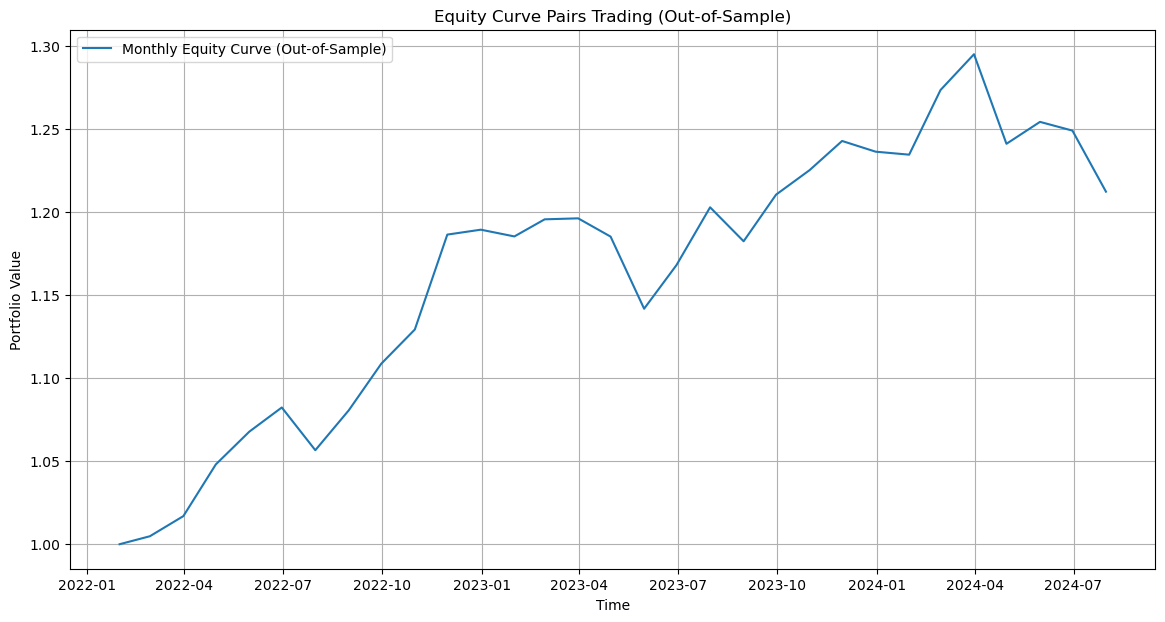

Out-of-Sample Performance:
Cumulative Return: 21.24%
Maximum Drawdown: -7.37%
Sharpe Ratio: 0.99
Number of Trades: 48


In [13]:
import pandas as pd
import numpy as np
import yfinance as yf
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import warnings
from ta.momentum import RSIIndicator
from ta.trend import MACD
from ta.volatility import BollingerBands

warnings.filterwarnings("ignore")

# Define your overall period
start = '2020-01-01'
end = '2024-08-01'

# Training and testing cut-off date
train_end = '2022-01-01'
test_start = '2022-01-02'  # The day after train_end

stock1 = yf.Ticker('HG=F')  
stock1_data = stock1.history(interval='1d', start=start, end=end)

stock2 = yf.Ticker('^RUT')  
stock2_data = stock2.history(interval='1d', start=start, end=end)

# Combine and log transform
aligned_data = pd.concat([stock1_data["Close"], stock2_data["Close"]], axis=1, keys=["Stock1", "Stock2"]).dropna()
aligned_data = np.log(aligned_data)
aligned_data.replace([np.inf, -np.inf], np.nan, inplace=True)
aligned_data.dropna(inplace=True)

# Split into train and test
train_data = aligned_data.loc[:train_end]
test_data = aligned_data.loc[test_start:end]

# Fit the regression on the training set
Y_train = train_data["Stock2"]
X_train = train_data["Stock1"]
X_train_const = sm.add_constant(X_train)
model = sm.OLS(Y_train, X_train_const)
results = model.fit()

alpha = results.params["const"]
beta = results.params["Stock1"]

# Apply the trained parameters to the test set
spread = test_data["Stock2"] - (alpha + beta * test_data["Stock1"])
test_data["Spread"] = spread

# Rolling statistics for Z-score on test set
window = 30
rolling_mean = spread.rolling(window=window).mean()
rolling_std = spread.rolling(window=window).std()
zscore = (spread - rolling_mean) / rolling_std
test_data["ZScore"] = zscore

# Add Technical Indicators on test data
rsi_period = 14
rsi_indicator = RSIIndicator(close=test_data["Spread"], window=rsi_period)
test_data["RSI"] = rsi_indicator.rsi()

macd_indicator = MACD(close=test_data["Spread"], window_slow=26, window_fast=12, window_sign=9)
test_data["MACD"] = macd_indicator.macd()
test_data["MACD_Signal"] = macd_indicator.macd_signal()

bb_indicator = BollingerBands(close=test_data["Spread"], window=20, window_dev=2)
test_data["BB_High"] = bb_indicator.bollinger_hband()
test_data["BB_Low"] = bb_indicator.bollinger_lband()

# Define signal thresholds
signal_entry = 1
signal_exit = 0.4

btest = pd.DataFrame(index=test_data.index)
btest["stock2"] = test_data["Stock2"]
btest["stock1"] = test_data["Stock1"]
btest["spread"] = test_data["Spread"]
btest["zscore"] = test_data["ZScore"]
btest["RSI"] = test_data["RSI"]
btest["MACD"] = test_data["MACD"]
btest["MACD_Signal"] = test_data["MACD_Signal"]
btest["BB_High"] = test_data["BB_High"]
btest["BB_Low"] = test_data["BB_Low"]

# Generate trading signals
btest["short signal"] = ((btest["zscore"] > signal_entry) & (btest["zscore"].shift(1) <= signal_entry))
btest["short exit"] = ((btest["zscore"] < signal_exit) & (btest["zscore"].shift(1) >= signal_exit))
btest["long signal"] = ((btest["zscore"] < -signal_entry) & (btest["zscore"].shift(1) >= -signal_entry))
btest["long exit"] = ((btest["zscore"] > -signal_exit) & (btest["zscore"].shift(1) <= -signal_exit))

# Optional filters (example): Only enter long if RSI < 70, short if RSI > 30
btest["long signal"] = btest["long signal"] & (btest["RSI"] < 70)
btest["short signal"] = btest["short signal"] & (btest["RSI"] > 30)

# Backtesting parameters
slippage = 0.001  # 0.1% slippage
transaction_cost = 0.001  # 0.1% transaction cost

spread_side = None
counter = -1
backtest_result = []
num_trades = 0

for time, signals_stock in btest.iterrows():
    counter += 1
    (stock2_, stock1_, spread_, zscore_,
     RSI_, MACD_, MACD_Signal_, BB_High_, BB_Low_,
     short_signal, short_exit, long_signal, long_exit) = signals_stock

    if spread_side is None:
        return_stock2 = 0
        return_stock1 = 0
        backtest_result.append([time, return_stock2, return_stock1, spread_side])

        # Entry signals
        if short_signal:
            spread_side = "short"
            num_trades += 1
        elif long_signal:
            spread_side = "long"
            num_trades += 1

    elif spread_side == "long":
        return_stock2 = btest["stock2"].iloc[counter] / btest["stock2"].iloc[counter - 1] - 1 - transaction_cost - slippage
        return_stock1 = btest["stock1"].iloc[counter] / btest["stock1"].iloc[counter - 1] - 1 - transaction_cost - slippage
        backtest_result.append([time, return_stock2, -return_stock1, spread_side])

        if long_exit:
            spread_side = None

    elif spread_side == "short":
        return_stock2 = btest["stock2"].iloc[counter] / btest["stock2"].iloc[counter - 1] - 1 - transaction_cost - slippage
        return_stock1 = btest["stock1"].iloc[counter] / btest["stock1"].iloc[counter - 1] - 1 - transaction_cost - slippage
        backtest_result.append([time, -return_stock2, return_stock1, spread_side])

        if short_exit:
            spread_side = None

# Create backtest results DataFrame
backtest_pandas = pd.DataFrame(backtest_result, columns=["Date", "stock2", "stock1", "Side"])
backtest_pandas["stock2 PL"] = np.cumprod(backtest_pandas["stock2"] + 1.)
backtest_pandas["stock1 PL"] = np.cumprod(backtest_pandas["stock1"] + 1.)
backtest_pandas["Total PL"] = (backtest_pandas["stock1 PL"] + backtest_pandas["stock2 PL"]) / 2.
backtest_pandas.set_index("Date", inplace=True)

# Resample to monthly data for plotting
monthly_equity = backtest_pandas["Total PL"].resample('M').last()

plt.figure(figsize=(14, 7))
plt.plot(monthly_equity.index, monthly_equity, label="Monthly Equity Curve (Out-of-Sample)")
plt.title("Equity Curve Pairs Trading (Out-of-Sample)")
plt.xlabel("Time")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid()
plt.show()

# Performance Metrics
cumulative_return = backtest_pandas["Total PL"].iloc[-1] - 1
drawdown = backtest_pandas["Total PL"] / backtest_pandas["Total PL"].cummax() - 1
max_drawdown = drawdown.min()
daily_returns = backtest_pandas["Total PL"].pct_change().dropna()
sharpe_ratio = daily_returns.mean() / daily_returns.std() * np.sqrt(252)

print("Out-of-Sample Performance:")
print(f"Cumulative Return: {cumulative_return * 100:.2f}%")
print(f"Maximum Drawdown: {max_drawdown * 100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Number of Trades: {num_trades}")


Best Parameters Found:
Z-Score Window: 30
Signal Entry: 1.2
Signal Exit: 0.3
RSI Filter: True
RSI Long Upper: 60
RSI Short Lower: 40
MACD Filter: False
Optimized Performance:
Cumulative Return: 3.60%
Maximum Drawdown: -6.42%
Sharpe Ratio: 0.19


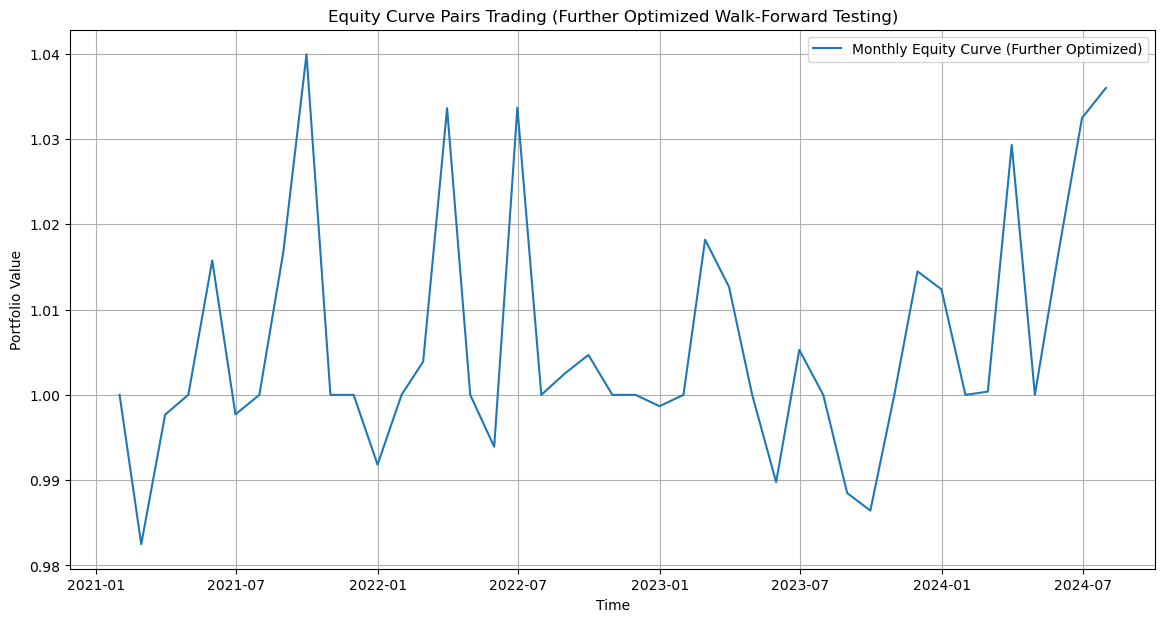

In [14]:
import pandas as pd
import numpy as np
import yfinance as yf
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import warnings
from ta.momentum import RSIIndicator
from ta.trend import MACD
from ta.volatility import BollingerBands
from datetime import timedelta

warnings.filterwarnings("ignore")

# Download data
start = '2020-01-01'
end = '2024-08-01'

stock1 = yf.Ticker('HG=F')  
stock1_data = stock1.history(interval='1d', start=start, end=end)

stock2 = yf.Ticker('^RUT')  
stock2_data = stock2.history(interval='1d', start=start, end=end)

aligned_data = pd.concat([stock1_data["Close"], stock2_data["Close"]], axis=1, keys=["Stock1", "Stock2"]).dropna()
aligned_data = np.log(aligned_data)
aligned_data.replace([np.inf, -np.inf], np.nan, inplace=True)
aligned_data.dropna(inplace=True)

# Parameters for walk-forward
train_period = pd.DateOffset(years=1)  # Train on 1-year data
test_period = pd.DateOffset(months=3)  # Test on next 3 months

# Expanded parameter grids
window_candidates = [20, 30, 60, 90]         # More window sizes
entry_candidates = [1.0, 1.2, 1.5]           # Vary entry thresholds
exit_candidates = [0.3, 0.4, 0.5]            # Vary exit thresholds
rsi_filter_candidates = [True, False]
rsi_long_upper_thresholds = [60, 70, 80]     # RSI upper bounds for long entries
rsi_short_lower_thresholds = [40, 30, 20]    # RSI lower bounds for short entries
use_macd_filter_candidates = [True, False]   # Whether to use MACD filter or not

best_sharpe = -np.inf
best_params = None
best_results = None

for window in window_candidates:
    for signal_entry in entry_candidates:
        for signal_exit in exit_candidates:
            for use_rsi_filter in rsi_filter_candidates:
                for rsi_long_upper in rsi_long_upper_thresholds:
                    for rsi_short_lower in rsi_short_lower_thresholds:
                        for use_macd_filter in use_macd_filter_candidates:
                            # Walk-forward testing
                            start_date = aligned_data.index[0] + train_period
                            end_date = aligned_data.index[-1]

                            all_results = []
                            current_start = start_date
                            slippage = 0.001
                            transaction_cost = 0.001

                            while current_start + test_period <= end_date:
                                # Training window
                                train_start = current_start - train_period
                                train_end = current_start
                                test_start = current_start + pd.DateOffset(days=1)
                                test_end = current_start + test_period

                                train_data = aligned_data.loc[train_start:train_end]
                                test_data = aligned_data.loc[test_start:test_end]

                                if len(train_data) < 30 or len(test_data) < 30:
                                    break

                                # Fit the model on training data
                                Y_train = train_data["Stock2"]
                                X_train = train_data["Stock1"]
                                X_train_const = sm.add_constant(X_train)
                                model = sm.OLS(Y_train, X_train_const)
                                results = model.fit()
                                alpha = results.params["const"]
                                beta = results.params["Stock1"]

                                # Apply to test data
                                spread = test_data["Stock2"] - (alpha + beta * test_data["Stock1"])
                                test_data["Spread"] = spread

                                # Calculate rolling stats on test data
                                rolling_mean = spread.rolling(window=window).mean()
                                rolling_std = spread.rolling(window=window).std()
                                zscore = (spread - rolling_mean) / rolling_std
                                test_data["ZScore"] = zscore

                                # Add indicators
                                rsi_period = 14
                                rsi_indicator = RSIIndicator(close=test_data["Spread"], window=rsi_period)
                                test_data["RSI"] = rsi_indicator.rsi()

                                macd_indicator = MACD(close=test_data["Spread"], window_slow=26, window_fast=12, window_sign=9)
                                test_data["MACD"] = macd_indicator.macd()
                                test_data["MACD_Signal"] = macd_indicator.macd_signal()

                                bb_indicator = BollingerBands(close=test_data["Spread"], window=20, window_dev=2)
                                test_data["BB_High"] = bb_indicator.bollinger_hband()
                                test_data["BB_Low"] = bb_indicator.bollinger_lband()

                                btest = pd.DataFrame(index=test_data.index)
                                btest["stock2"] = test_data["Stock2"]
                                btest["stock1"] = test_data["Stock1"]
                                btest["spread"] = test_data["Spread"]
                                btest["zscore"] = test_data["ZScore"]
                                btest["RSI"] = test_data["RSI"]
                                btest["MACD"] = test_data["MACD"]
                                btest["MACD_Signal"] = test_data["MACD_Signal"]
                                btest["BB_High"] = test_data["BB_High"]
                                btest["BB_Low"] = test_data["BB_Low"]

                                # Signals
                                btest["short signal"] = ((btest["zscore"] > signal_entry) & (btest["zscore"].shift(1) <= signal_entry))
                                btest["short exit"] = ((btest["zscore"] < signal_exit) & (btest["zscore"].shift(1) >= signal_exit))
                                btest["long signal"] = ((btest["zscore"] < -signal_entry) & (btest["zscore"].shift(1) >= -signal_entry))
                                btest["long exit"] = ((btest["zscore"] > -signal_exit) & (btest["zscore"].shift(1) <= -signal_exit))

                                # Apply RSI Filter if chosen
                                if use_rsi_filter:
                                    # Only go long if RSI < rsi_long_upper
                                    btest["long signal"] = btest["long signal"] & (btest["RSI"] < rsi_long_upper)
                                    # Only go short if RSI > rsi_short_lower
                                    btest["short signal"] = btest["short signal"] & (btest["RSI"] > rsi_short_lower)

                                # Apply MACD Filter if chosen
                                if use_macd_filter:
                                    # For longs: MACD > MACD_Signal
                                    btest["long signal"] = btest["long signal"] & (btest["MACD"] > btest["MACD_Signal"])
                                    # For shorts: MACD < MACD_Signal
                                    btest["short signal"] = btest["short signal"] & (btest["MACD"] < btest["MACD_Signal"])

                                spread_side = None
                                counter = -1
                                backtest_result = []
                                num_trades = 0

                                # Run backtest on test segment
                                for time, signals_stock in btest.iterrows():
                                    counter += 1
                                    (stock2_, stock1_, spread_, zscore_,
                                     RSI_, MACD_, MACD_Signal_, BB_High_, BB_Low_,
                                     short_signal, short_exit, long_signal, long_exit) = signals_stock

                                    if spread_side is None:
                                        return_stock2 = 0
                                        return_stock1 = 0
                                        backtest_result.append([time, return_stock2, return_stock1, spread_side])
                                        if short_signal:
                                            spread_side = "short"
                                            num_trades += 1
                                        elif long_signal:
                                            spread_side = "long"
                                            num_trades += 1

                                    elif spread_side == "long":
                                        return_stock2 = btest["stock2"].iloc[counter] / btest["stock2"].iloc[counter - 1] - 1 - transaction_cost - slippage
                                        return_stock1 = btest["stock1"].iloc[counter] / btest["stock1"].iloc[counter - 1] - 1 - transaction_cost - slippage
                                        backtest_result.append([time, return_stock2, -return_stock1, spread_side])

                                        if long_exit:
                                            spread_side = None

                                    elif spread_side == "short":
                                        return_stock2 = btest["stock2"].iloc[counter] / btest["stock2"].iloc[counter - 1] - 1 - transaction_cost - slippage
                                        return_stock1 = btest["stock1"].iloc[counter] / btest["stock1"].iloc[counter - 1] - 1 - transaction_cost - slippage
                                        backtest_result.append([time, -return_stock2, return_stock1, spread_side])

                                        if short_exit:
                                            spread_side = None

                                if len(backtest_result) > 0:
                                    backtest_pandas = pd.DataFrame(backtest_result, columns=["Date", "stock2", "stock1", "Side"])
                                    backtest_pandas["stock2 PL"] = np.cumprod(backtest_pandas["stock2"] + 1.)
                                    backtest_pandas["stock1 PL"] = np.cumprod(backtest_pandas["stock1"] + 1.)
                                    backtest_pandas["Total PL"] = (backtest_pandas["stock1 PL"] + backtest_pandas["stock2 PL"]) / 2.
                                    backtest_pandas.set_index("Date", inplace=True)
                                    all_results.append(backtest_pandas)

                                # Move the training/testing window forward for the next iteration
                                current_start = test_end

                            # Combine all walk-forward segments for this parameter set
                            if all_results:
                                combined_results = pd.concat(all_results)
                                combined_results = combined_results[~combined_results.index.duplicated(keep='first')]

                                daily_returns = combined_results["Total PL"].pct_change().dropna()
                                if daily_returns.std() == 0:
                                    # Avoid division by zero if no variation
                                    current_sharpe = -999
                                else:
                                    current_sharpe = daily_returns.mean() / daily_returns.std() * np.sqrt(252)

                                # Track the best Sharpe ratio found
                                if current_sharpe > best_sharpe:
                                    best_sharpe = current_sharpe
                                    best_params = (window, signal_entry, signal_exit, use_rsi_filter, rsi_long_upper, rsi_short_lower, use_macd_filter)
                                    best_results = combined_results


walkforward_results = best_results

# Print and plot the best results
if best_results is not None:
    print("Best Parameters Found:")
    print(f"Z-Score Window: {best_params[0]}")
    print(f"Signal Entry: {best_params[1]}")
    print(f"Signal Exit: {best_params[2]}")
    print(f"RSI Filter: {best_params[3]}")
    print(f"RSI Long Upper: {best_params[4]}")
    print(f"RSI Short Lower: {best_params[5]}")
    print(f"MACD Filter: {best_params[6]}")
    
    daily_returns = best_results["Total PL"].pct_change().dropna()
    cumulative_return = best_results["Total PL"].iloc[-1] - 1
    drawdown = best_results["Total PL"] / best_results["Total PL"].cummax() - 1
    max_drawdown = drawdown.min()
    print("Optimized Performance:")
    print(f"Cumulative Return: {cumulative_return * 100:.2f}%")
    print(f"Maximum Drawdown: {max_drawdown * 100:.2f}%")
    print(f"Sharpe Ratio: {best_sharpe:.2f}")

    # Plot monthly equity curve for best result
    monthly_equity = best_results["Total PL"].resample('M').last()
    plt.figure(figsize=(14, 7))
    plt.plot(monthly_equity.index, monthly_equity, label="Monthly Equity Curve (Further Optimized)")
    plt.title("Equity Curve Pairs Trading (Further Optimized Walk-Forward Testing)")
    plt.xlabel("Time")
    plt.ylabel("Portfolio Value")
    plt.legend()
    plt.grid()
    plt.show()
else:
    print("No results generated. Check your parameter ranges and data availability.")


In [15]:
#INSAMPLE BACKTEST

import pandas as pd
import numpy as np
import yfinance as yf
import statsmodels.api as sm
import matplotlib.pyplot as plt
from ta.momentum import RSIIndicator
from ta.trend import MACD
from ta.volatility import BollingerBands
import warnings
warnings.filterwarnings("ignore")

# Data
start = '2020-01-01'
end = '2024-08-01'

stock1 = yf.Ticker('HG=F')  
stock1_data = stock1.history(interval='1d', start=start, end=end)

stock2 = yf.Ticker('^RUT')  
stock2_data = stock2.history(interval='1d', start=start, end=end)

aligned_data = pd.concat([stock1_data["Close"], stock2_data["Close"]], axis=1, keys=["Stock1", "Stock2"]).dropna()
aligned_data = np.log(aligned_data)
aligned_data.replace([np.inf, -np.inf], np.nan, inplace=True)
aligned_data.dropna(inplace=True)

# Fit model on the entire dataset (in-sample)
Y = aligned_data["Stock2"]
X = aligned_data["Stock1"]
X_const = sm.add_constant(X)
model = sm.OLS(Y, X_const)
results = model.fit()
alpha = results.params["const"]
beta = results.params["Stock1"]

spread = Y - (alpha + beta * X)
window = 30
rolling_mean = spread.rolling(window=window).mean()
rolling_std = spread.rolling(window=window).std()
zscore = (spread - rolling_mean) / rolling_std

aligned_data["Spread"] = spread
aligned_data["ZScore"] = zscore

# Indicators
rsi_period = 14
rsi_indicator = RSIIndicator(close=aligned_data["Spread"], window=rsi_period)
aligned_data["RSI"] = rsi_indicator.rsi()

macd_indicator = MACD(close=aligned_data["Spread"], window_slow=26, window_fast=12, window_sign=9)
aligned_data["MACD"] = macd_indicator.macd()
aligned_data["MACD_Signal"] = macd_indicator.macd_signal()

bb_indicator = BollingerBands(close=aligned_data["Spread"], window=20, window_dev=2)
aligned_data["BB_High"] = bb_indicator.bollinger_hband()
aligned_data["BB_Low"] = bb_indicator.bollinger_lband()

btest = pd.DataFrame(index=aligned_data.index)
btest["stock2"] = aligned_data["Stock2"]
btest["stock1"] = aligned_data["Stock1"]
btest["spread"] = aligned_data["Spread"]
btest["zscore"] = aligned_data["ZScore"]
btest["RSI"] = aligned_data["RSI"]
btest["MACD"] = aligned_data["MACD"]
btest["MACD_Signal"] = aligned_data["MACD_Signal"]
btest["BB_High"] = aligned_data["BB_High"]
btest["BB_Low"] = aligned_data["BB_Low"]

signal_entry = 1.2
signal_exit = 0.3
# Example conditions
btest["short signal"] = ((btest["zscore"] > signal_entry) & (btest["zscore"].shift(1) <= signal_entry))
btest["short exit"] = ((btest["zscore"] < signal_exit) & (btest["zscore"].shift(1) >= signal_exit))
btest["long signal"] = ((btest["zscore"] < -signal_entry) & (btest["zscore"].shift(1) >= -signal_entry))
btest["long exit"] = ((btest["zscore"] > -signal_exit) & (btest["zscore"].shift(1) <= -signal_exit))

# Add RSI filters as before (optional)
btest["long signal"] = btest["long signal"] & (btest["RSI"] < 70)
btest["short signal"] = btest["short signal"] & (btest["RSI"] > 30)

slippage = 0.001
transaction_cost = 0.001

spread_side = None
counter = -1
backtest_result = []
num_trades = 0

for time, signals_stock in btest.iterrows():
    counter += 1
    (stock2_, stock1_, spread_, zscore_,
     RSI_, MACD_, MACD_Signal_, BB_High_, BB_Low_,
     short_signal, short_exit, long_signal, long_exit) = signals_stock

    if spread_side is None:
        return_stock2 = 0
        return_stock1 = 0
        backtest_result.append([time, return_stock2, return_stock1, spread_side])
        if short_signal:
            spread_side = "short"
            num_trades += 1
        elif long_signal:
            spread_side = "long"
            num_trades += 1

    elif spread_side == "long":
        return_stock2 = btest["stock2"].iloc[counter] / btest["stock2"].iloc[counter - 1] - 1 - transaction_cost - slippage
        return_stock1 = btest["stock1"].iloc[counter] / btest["stock1"].iloc[counter - 1] - 1 - transaction_cost - slippage
        backtest_result.append([time, return_stock2, -return_stock1, spread_side])

        if long_exit:
            spread_side = None

    elif spread_side == "short":
        return_stock2 = btest["stock2"].iloc[counter] / btest["stock2"].iloc[counter - 1] - 1 - transaction_cost - slippage
        return_stock1 = btest["stock1"].iloc[counter] / btest["stock1"].iloc[counter - 1] - 1 - transaction_cost - slippage
        backtest_result.append([time, -return_stock2, return_stock1, spread_side])

        if short_exit:
            spread_side = None

insample_results = pd.DataFrame(backtest_result, columns=["Date", "stock2", "stock1", "Side"])
insample_results.set_index("Date", inplace=True)
insample_results["stock2 PL"] = np.cumprod(insample_results["stock2"] + 1.)
insample_results["stock1 PL"] = np.cumprod(insample_results["stock1"] + 1.)
insample_results["Total PL"] = (insample_results["stock1 PL"] + insample_results["stock2 PL"]) / 2.


In [20]:
#OUTSAMPLE_BACKTEST
train_end = '2022-01-01'
test_start = '2022-01-02'

train_data = aligned_data.loc[:train_end]
test_data = aligned_data.loc[test_start:end]

# Fit on train
Y_train = train_data["Stock2"]
X_train = train_data["Stock1"]
X_train_const = sm.add_constant(X_train)
model = sm.OLS(Y_train, X_train_const)
results = model.fit()
alpha = results.params["const"]
beta = results.params["Stock1"]

spread_test = test_data["Stock2"] - (alpha + beta * test_data["Stock1"])
test_data["Spread"] = spread_test

rolling_mean = spread_test.rolling(window=window).mean()
rolling_std = spread_test.rolling(window=window).std()
zscore_test = (spread_test - rolling_mean) / rolling_std
test_data["ZScore"] = zscore_test

# Indicators on test data
rsi_indicator = RSIIndicator(close=test_data["Spread"], window=rsi_period)
test_data["RSI"] = rsi_indicator.rsi()

macd_indicator = MACD(close=test_data["Spread"], window_slow=26, window_fast=12, window_sign=9)
test_data["MACD"] = macd_indicator.macd()
test_data["MACD_Signal"] = macd_indicator.macd_signal()

bb_indicator = BollingerBands(close=test_data["Spread"], window=20, window_dev=2)
test_data["BB_High"] = bb_indicator.bollinger_hband()
test_data["BB_Low"] = bb_indicator.bollinger_lband()

btest_oos = pd.DataFrame(index=test_data.index)
btest_oos["stock2"] = test_data["Stock2"]
btest_oos["stock1"] = test_data["Stock1"]
btest_oos["spread"] = test_data["Spread"]
btest_oos["zscore"] = test_data["ZScore"]
btest_oos["RSI"] = test_data["RSI"]
btest_oos["MACD"] = test_data["MACD"]
btest_oos["MACD_Signal"] = test_data["MACD_Signal"]
btest_oos["BB_High"] = test_data["BB_High"]
btest_oos["BB_Low"] = test_data["BB_Low"]

btest_oos["short signal"] = ((btest_oos["zscore"] > signal_entry) & (btest_oos["zscore"].shift(1) <= signal_entry))
btest_oos["short exit"] = ((btest_oos["zscore"] < signal_exit) & (btest_oos["zscore"].shift(1) >= signal_exit))
btest_oos["long signal"] = ((btest_oos["zscore"] < -signal_entry) & (btest_oos["zscore"].shift(1) >= -signal_entry))
btest_oos["long exit"] = ((btest_oos["zscore"] > -signal_exit) & (btest_oos["zscore"].shift(1) <= -signal_exit))

btest_oos["long signal"] = btest_oos["long signal"] & (btest_oos["RSI"] < 70)
btest_oos["short signal"] = btest_oos["short signal"] & (btest_oos["RSI"] > 30)

spread_side = None
counter = -1
backtest_result_oos = []
num_trades_oos = 0

for time, signals_stock in btest_oos.iterrows():
    counter += 1
    (stock2_, stock1_, spread_, zscore_,
     RSI_, MACD_, MACD_Signal_, BB_High_, BB_Low_,
     short_signal, short_exit, long_signal, long_exit) = signals_stock

    if spread_side is None:
        return_stock2 = 0
        return_stock1 = 0
        backtest_result_oos.append([time, return_stock2, return_stock1, spread_side])
        if short_signal:
            spread_side = "short"
            num_trades_oos += 1
        elif long_signal:
            spread_side = "long"
            num_trades_oos += 1

    elif spread_side == "long":
        return_stock2 = btest_oos["stock2"].iloc[counter] / btest_oos["stock2"].iloc[counter - 1] - 1 - transaction_cost - slippage
        return_stock1 = btest_oos["stock1"].iloc[counter] / btest_oos["stock1"].iloc[counter - 1] - 1 - transaction_cost - slippage
        backtest_result_oos.append([time, return_stock2, -return_stock1, spread_side])

        if long_exit:
            spread_side = None

    elif spread_side == "short":
        return_stock2 = btest_oos["stock2"].iloc[counter] / btest_oos["stock2"].iloc[counter - 1] - 1 - transaction_cost - slippage
        return_stock1 = btest_oos["stock1"].iloc[counter] / btest_oos["stock1"].iloc[counter - 1] - 1 - transaction_cost - slippage
        backtest_result_oos.append([time, -return_stock2, return_stock1, spread_side])

        if short_exit:
            spread_side = None

outsample_results = pd.DataFrame(backtest_result_oos, columns=["Date", "stock2", "stock1", "Side"])
outsample_results.set_index("Date", inplace=True)
outsample_results["stock2 PL"] = np.cumprod(outsample_results["stock2"] + 1.)
outsample_results["stock1 PL"] = np.cumprod(outsample_results["stock1"] + 1.)
outsample_results["Total PL"] = (outsample_results["stock1 PL"] + outsample_results["stock2 PL"]) / 2.


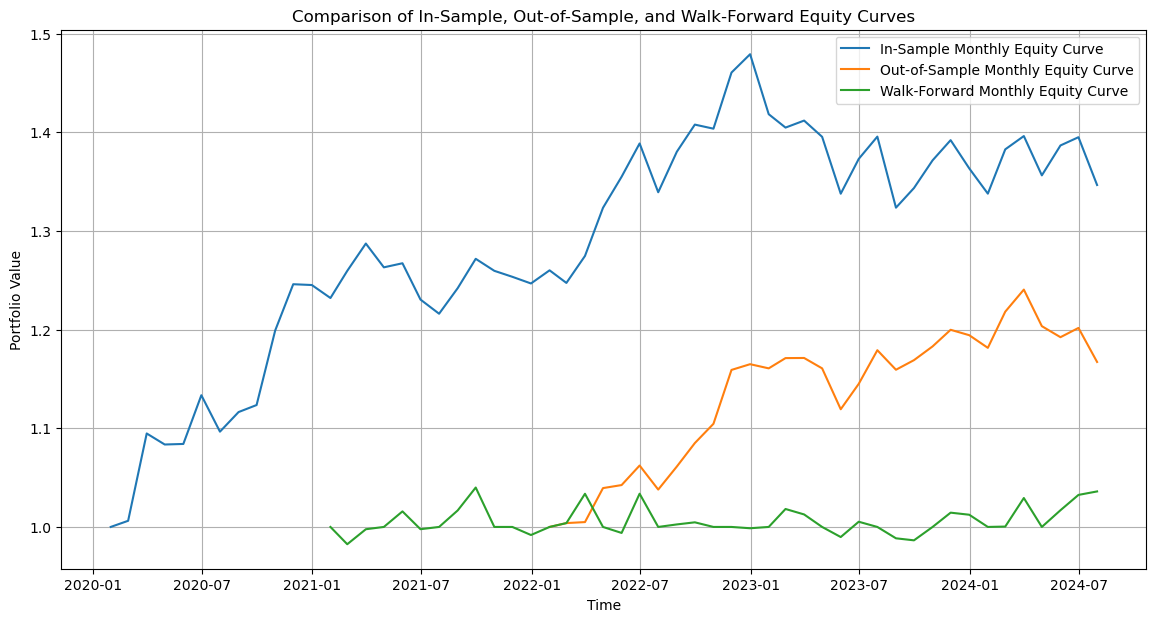

In [21]:
# Resample each equity curve to monthly frequency
insample_monthly = insample_results["Total PL"].resample('M').last()
outsample_monthly = outsample_results["Total PL"].resample('M').last()
walkforward_monthly = walkforward_results["Total PL"].resample('M').last()

# Create the plot
plt.figure(figsize=(14, 7))
plt.plot(insample_monthly.index, insample_monthly, label="In-Sample Monthly Equity Curve")
plt.plot(outsample_monthly.index, outsample_monthly, label="Out-of-Sample Monthly Equity Curve")
plt.plot(walkforward_monthly.index, walkforward_monthly, label="Walk-Forward Monthly Equity Curve")

plt.title("Comparison of In-Sample, Out-of-Sample, and Walk-Forward Equity Curves")
plt.xlabel("Time")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid()
plt.show()


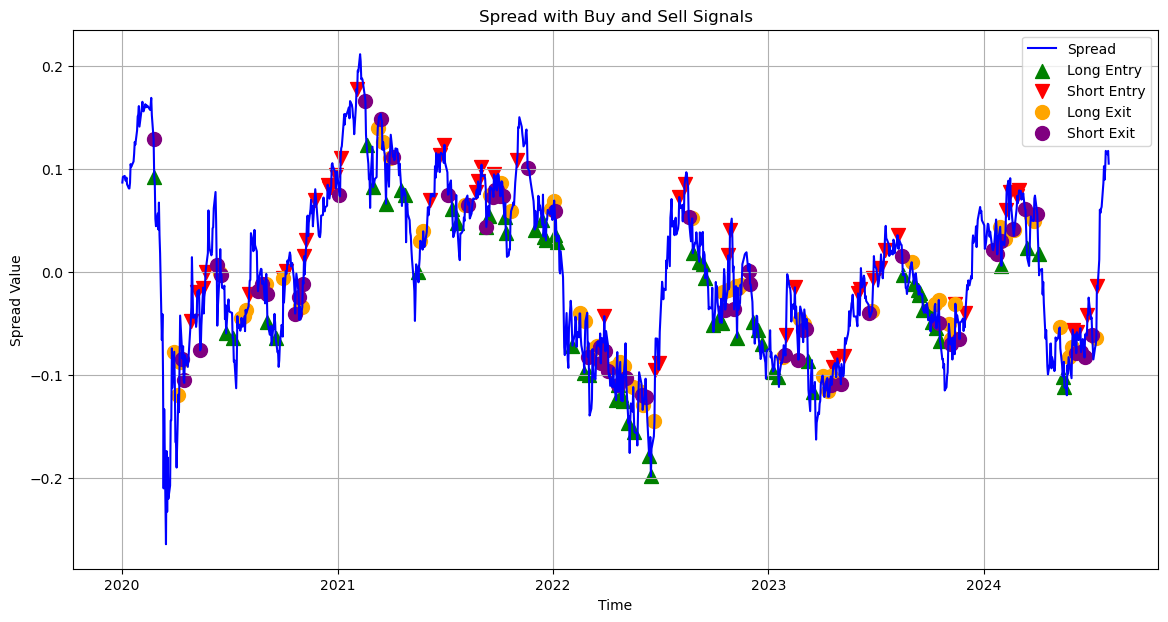

In [22]:
# Assuming `btest` DataFrame has your signals and prices, similar to previous code:
# btest["stock1"], btest["stock2"], btest["zscore"], btest["long signal"], btest["short signal"], etc.

plt.figure(figsize=(14,7))
plt.plot(btest.index, btest["spread"], label='Spread', color='blue')

# Mark long entries (buy signals)
long_entries = btest[btest["long signal"]]
plt.scatter(long_entries.index, btest.loc[long_entries.index, "spread"], 
            marker='^', color='green', s=100, label='Long Entry')

# Mark short entries (sell signals)
short_entries = btest[btest["short signal"]]
plt.scatter(short_entries.index, btest.loc[short_entries.index, "spread"], 
            marker='v', color='red', s=100, label='Short Entry')

# If you have exit signals, mark them as well
long_exits = btest[btest["long exit"]]
plt.scatter(long_exits.index, btest.loc[long_exits.index, "spread"], 
            marker='o', color='orange', s=100, label='Long Exit')

short_exits = btest[btest["short exit"]]
plt.scatter(short_exits.index, btest.loc[short_exits.index, "spread"], 
            marker='o', color='purple', s=100, label='Short Exit')

plt.title("Spread with Buy and Sell Signals")
plt.xlabel("Time")
plt.ylabel("Spread Value")
plt.grid(True)
plt.legend()
plt.show()


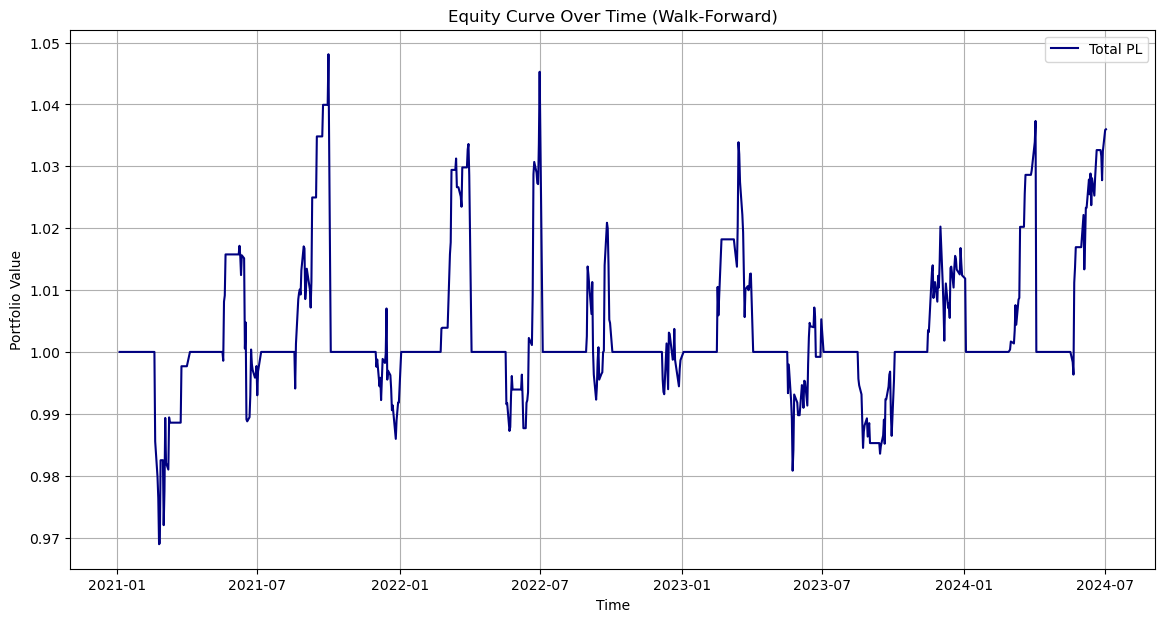

In [24]:
# Assuming `backtest_pandas` or `walkforward_results` DataFrame with "Total PL"
plt.figure(figsize=(14,7))
plt.plot(walkforward_results.index, walkforward_results["Total PL"], label="Total PL", color='navy')
plt.title("Equity Curve Over Time (Walk-Forward)")
plt.xlabel("Time")
plt.ylabel("Portfolio Value")
plt.grid(True)
plt.legend()
plt.show()


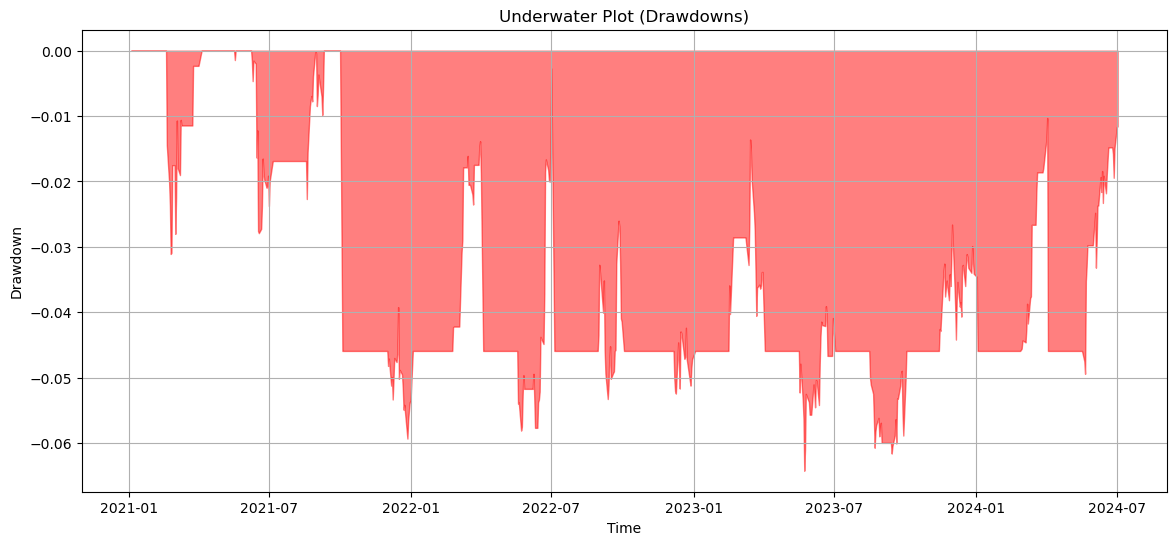

In [34]:
equity = walkforward_results["Total PL"]
running_max = equity.cummax()
drawdown = (equity / running_max) - 1

plt.figure(figsize=(14,6))
plt.fill_between(drawdown.index, drawdown, 0, color='red', alpha=0.5)
plt.title("Underwater Plot (Drawdowns)")
plt.xlabel("Time")
plt.ylabel("Drawdown")
plt.grid(True)
plt.show()


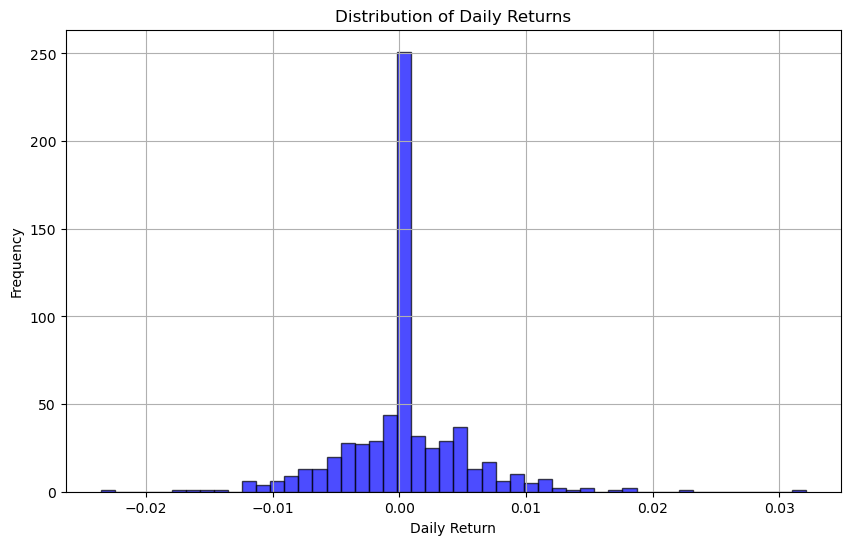

In [30]:
daily_returns = outsample_results["Total PL"].pct_change().dropna()

plt.figure(figsize=(10,6))
plt.hist(daily_returns, bins=50, color='blue', edgecolor='black', alpha=0.7)
plt.title("Distribution of Daily Returns")
plt.xlabel("Daily Return")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


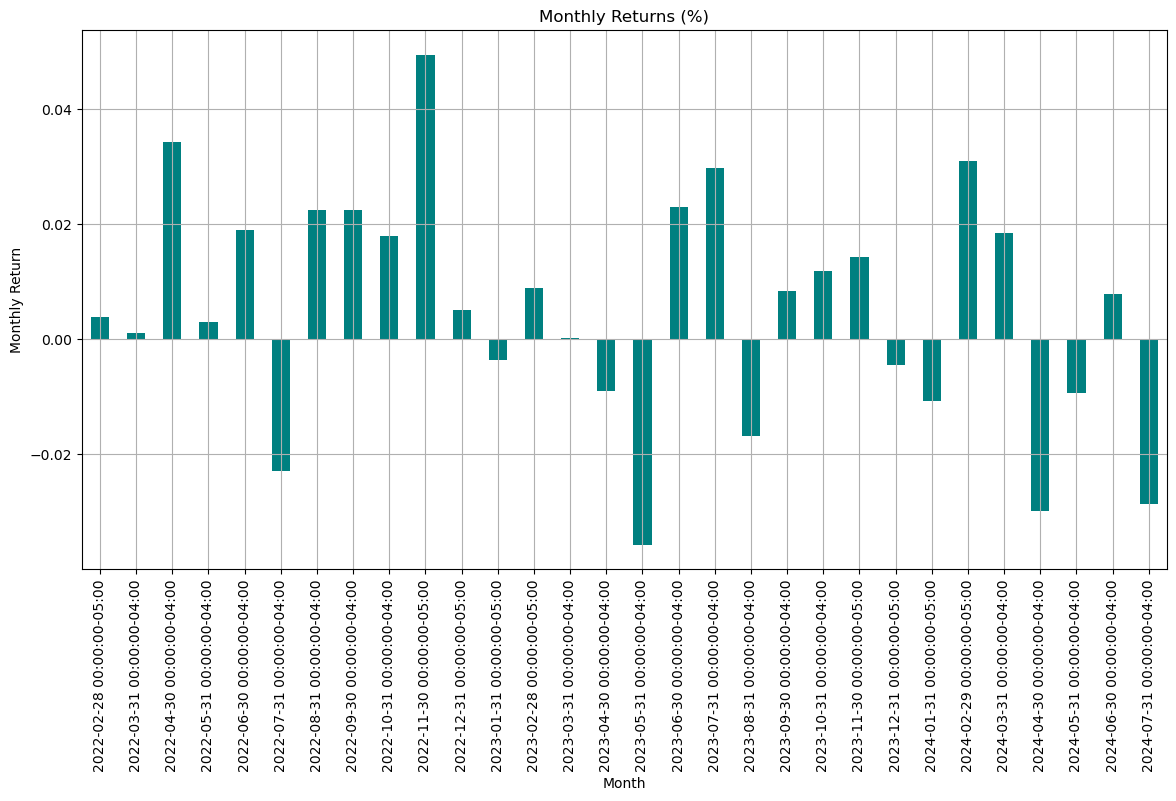

In [29]:
monthly_returns = outsample_results["Total PL"].resample('M').last().pct_change().dropna()

plt.figure(figsize=(14,7))
monthly_returns.plot(kind='bar', color='teal')
plt.title("Monthly Returns (%)")
plt.xlabel("Month")
plt.ylabel("Monthly Return")
plt.grid(True)
plt.show()


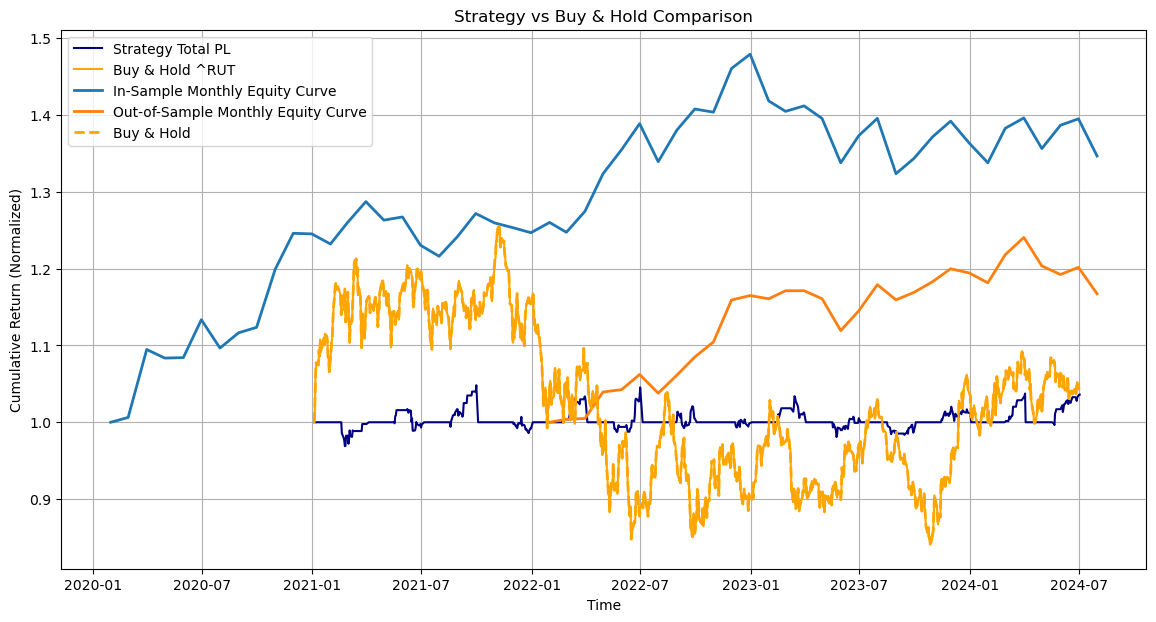

In [66]:
import matplotlib.pyplot as plt

# Assume walkforward_results is your strategy's performance with a "Total PL" column

# Let's say we compare to a buy-and-hold of Stock2_data (the second asset)
# If you have the original prices in stock2_data: 
# Note: If you've only retained log prices, you can re-download or use original data.

start_date = walkforward_results.index[0]
end_date = walkforward_results.index[-1]

# Download raw prices again if needed (or if you already have it, just use stock2_data)
benchmark_symbol = "^RUT"
benchmark = yf.Ticker(benchmark_symbol)
benchmark_data = benchmark.history(interval='1d', start=start_date, end=end_date)

# Compute buy-and-hold returns:
# Start with a normalized value of 1.0 at the first date
bh_price = benchmark_data["Close"]
bh_returns = bh_price / bh_price.iloc[0]  # Normalized to 1 at start

# Plot the strategy vs buy and hold
plt.figure(figsize=(14,7))
plt.plot(walkforward_results.index, walkforward_results["Total PL"], label="Strategy Total PL", color='navy')
plt.plot(bh_returns.index, bh_returns, label=f"Buy & Hold {benchmark_symbol}", color='orange')

#plt.figure(figsize=(14, 7))
plt.plot(insample_monthly.index, insample_monthly, label="In-Sample Monthly Equity Curve", linewidth=2)
plt.plot(outsample_monthly.index, outsample_monthly, label="Out-of-Sample Monthly Equity Curve", linewidth=2)
#plt.plot(walkforward_monthly.index, walkforward_monthly, label="Walk-Forward Monthly Equity Curve", linewidth=2)
plt.plot(bh_returns.index, bh_returns, label=f"Buy & Hold", linestyle='--', linewidth=2, color='orange')








plt.title("Strategy vs Buy & Hold Comparison")
plt.xlabel("Time")
plt.ylabel("Cumulative Return (Normalized)")
plt.grid(True)
plt.legend()
plt.show()
